In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import metrics
import cv2
import torch
import os
import sys
import pickle
device= "cuda" if torch.cuda.is_available() else "cpu"
from tokenize_image import Tokenize_img

In [30]:
dataset_path = r'E:\Datasets\rock_paper_scissors'
classes = {0: 'rock', 1: 'paper', 2: 'scissors', 3: 'background'}

# Class for tokenize an image
class Image_embeddings():
    def __init__(self, cuda=True, model='resnet-18', layer_output_size=512):
        self.use_cuda = cuda
        self.model = model
        self.layer_output_size = layer_output_size
        self.img2vec = Tokenize_img(cuda=self.use_cuda, model=self.model, layer_output_size=self.layer_output_size)

    def __call__(self, image):
        emb_vec = self.img2vec.get_vec(image) #Embedding Vector of the codified image
        return emb_vec

#Draw text with bakground on image
def draw_text(img, text,
          font=cv2.FONT_HERSHEY_PLAIN,
          pos=(0, 0),
          font_scale=3,
          font_thickness=2,
          text_color=(0, 255, 0),
          text_color_bg=(0, 0, 0)
          ):

    x, y = pos
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size
    cv2.rectangle(img, pos, (x + text_w, y + text_h + 10), text_color_bg, -1)
    cv2.putText(img, text, (int(x), int(y + text_h + font_scale - 1)), font, font_scale, text_color, font_thickness)

    return text_size  

### Embedded image dataset

In [6]:
embedder = Image_embeddings()
emb_df = []
targets = []
for sign in classes.keys():
    filenames = os.listdir(os.path.join(dataset_path, f'{classes[sign]}'))
    for i, file in enumerate(filenames):
        with Image.open(fp=os.path.join(dataset_path, f'{classes[sign]}', file), mode='r') as img:
            vector = embedder(img)
            vector = np.hstack([vector, sign, file])
            #emb_df.append(pd.Series(data=[vector, sign], index=['vector', 'sign']))
            emb_df.append(vector)

#emb_df: [samples:2717, n_features:512 + 1(class), filename]
p_train = 0.8
emb_df = pd.DataFrame(emb_df)

train_df, test_df = train_test_split(emb_df, test_size = 0.20)

#Get target labels
train_targets = train_df.iloc[:,-2].astype(int)
test_targets = test_df.iloc[:,-2].astype(int)

train_filenames = train_df.iloc[:,-1]
test_filenames = test_df.iloc[:,-1]

train_df = train_df.iloc[:,:-2]
test_df = test_df.iloc[:,:-2]

### Model train

In [5]:
model = svm.SVC() #defaul_kernel: rbf
model.fit(train_df, train_targets)

y_pred = model.predict(test_df)
print("Accuracy SVM:", metrics.accuracy_score(test_targets, y_pred))
print("SMV Report:\n", metrics.classification_report(y_true=test_targets, y_pred=y_pred, target_names=list(classes.values())))

#model_2 = LogisticRegression(max_iter=100000)
#model_2.fit(train_df, train_targets)
#y_pred_2 = model_2.predict(test_df)
#print("Accuracy Logistic Regression:", metrics.accuracy_score(test_targets, y_pred_2))
#print("Logistic Regression Report:\n", metrics.classification_report(y_true=test_targets, y_pred=y_pred_2, target_names=list(classes.values())))

# save the model to disk
filename = r'models\best_SVM_w_background.sav'
#pickle.dump(model_2, open(filename, 'wb'))

Accuracy Logistic Regression: 0.9940828402366864
Logistic Regression Report:
               precision    recall  f1-score   support

        rock       1.00      1.00      1.00       181
       paper       0.99      0.98      0.99       180
    scissors       0.98      0.99      0.99       193
  background       1.00      1.00      1.00       122

    accuracy                           0.99       676
   macro avg       0.99      0.99      0.99       676
weighted avg       0.99      0.99      0.99       676



### Results visualization

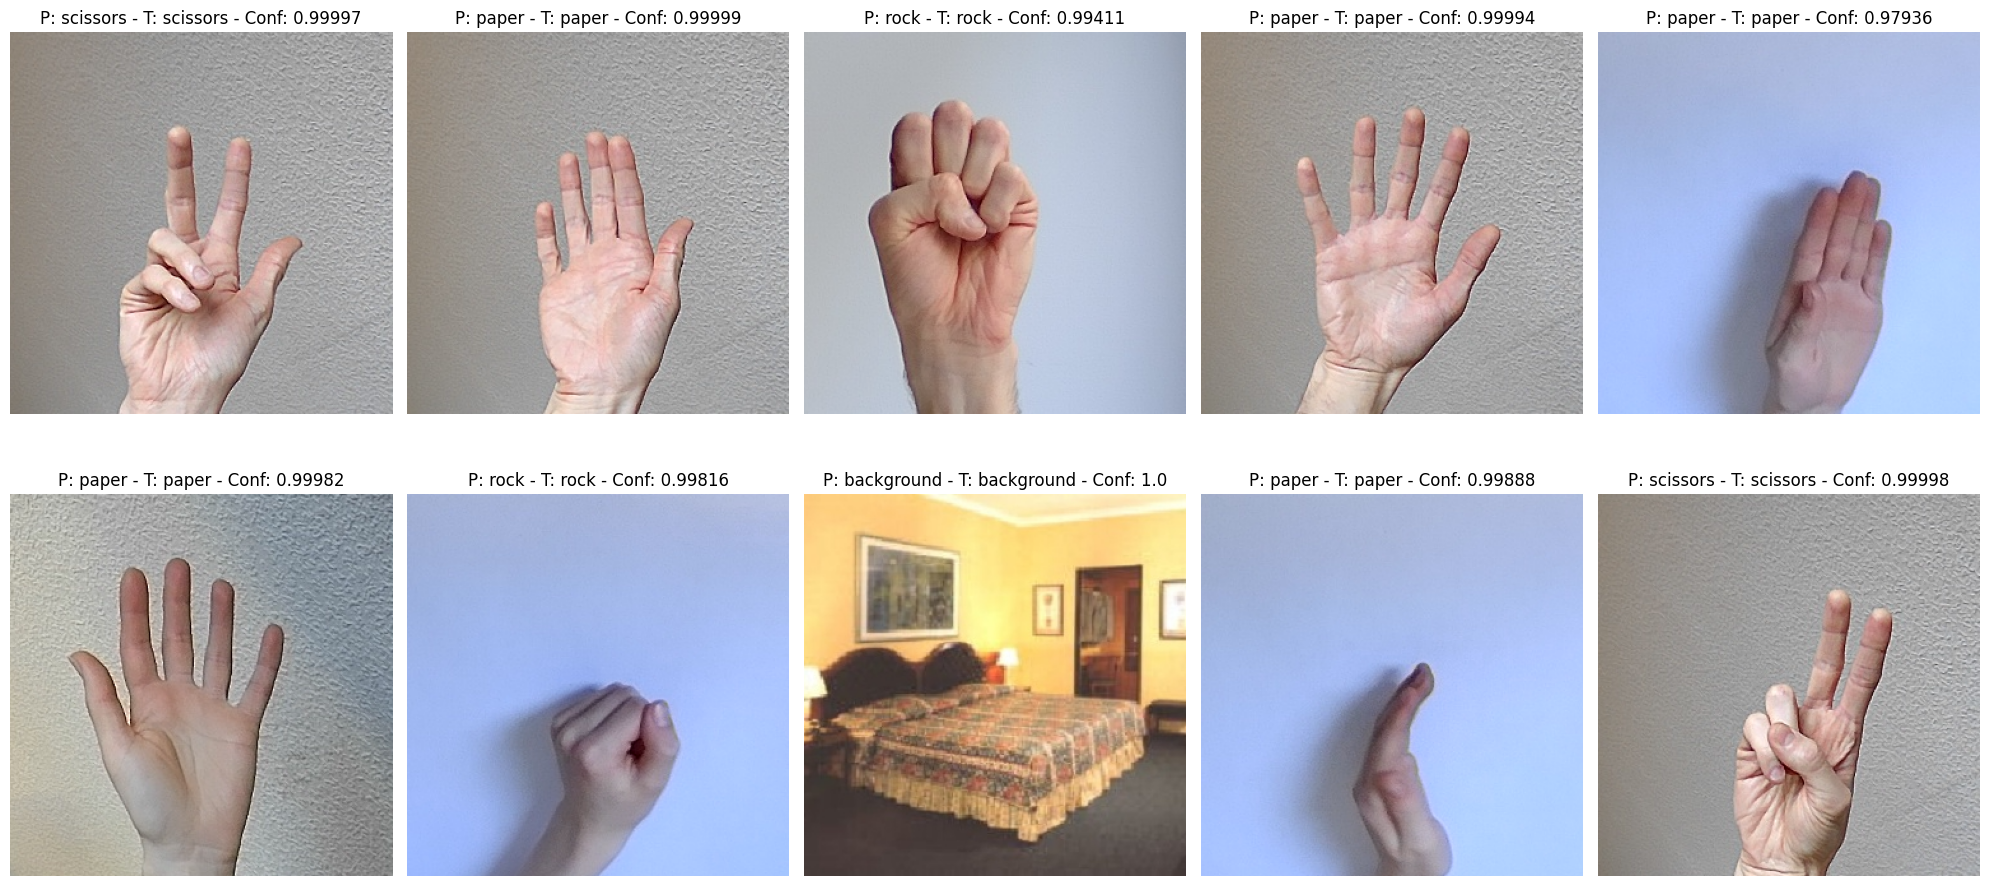

In [10]:
filename = r'models\best_SVM_w_background.sav'
model = pickle.load(open(filename, 'rb'))

random_images_filenames = np.random.choice(test_filenames, 10)
embedder_test = Image_embeddings()
pred_label, real_label, score, images = [], [], [], []
for image_path in random_images_filenames:
    image_complete_path = os.path.join(dataset_path, image_path.split(sep='_')[0], image_path)
    with Image.open(fp=image_complete_path, mode='r') as img:
        vector = embedder(img)
        score.append((model.predict_proba([vector])).max(axis=1)[0])
        pred_label.append(model.predict([vector])[0])
        real_label.append(image_path.split(sep='_')[0])
        images.append(img)

fig, axs = plt.subplots(2, 5, figsize=(20,10))
for i in range(2):
    for j in range(5):
        # Image index
        idx = i * 5 + j
        # Are there still images to show?
        if idx < len(images):
            axs[i, j].imshow(images[idx])
            axs[i, j].axis('off')
            axs[i, j].set_title(f'P: {classes[pred_label[idx]]} - T: {real_label[idx]} - Conf: {np.round(score[idx], 5)}')
fig.tight_layout()
plt.show()

### Video-stream test

In [35]:
filename = r'models\best_SVM_w_background.sav'
model = pickle.load(open(filename, 'rb'))
threshold = 0.65

#Video Configuration
cap = cv2.VideoCapture(0)
video_size = (1280, 720)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, video_size[0])
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, video_size[1])

# Codec and VideoWriter
codec = cv2.VideoWriter_fourcc(*'MP4V')
fps = cap.get(cv2.CAP_PROP_FPS) #10
video_writer = cv2.VideoWriter(r'.\outputs\output.mp4', codec, fps, video_size)

while cap.isOpened():
    success, frame = cap.read()
    frame = cv2.flip(frame, 1)
    if not success:
        print("Video frame is empty or video processing has been successfully completed.")
        break
    
    #rectangle = [(100, 100), (500, 500)]
    rectangle = [(800, 100), (1200, 500)]
    cutted_frame = frame[rectangle[0][1]:rectangle[1][1], rectangle[0][0]:rectangle[1][0]]
    cutted_frame = cv2.resize(cutted_frame, (300,300))
    img = Image.fromarray(cv2.cvtColor(cutted_frame, cv2.COLOR_BGR2RGB))
    #cv2.imshow('Img',img)
    vector = embedder(img)
    pred = model.predict_proba([vector])
    pred_label = pred.argmax(axis=1)[0]
    score = pred.max(axis=1)[0]
    
    if score > threshold:
        show_label = pred_label
        show_score = score

    cv2.rectangle(frame, rectangle[0], rectangle[1], (0,0,255), 4)
    draw_text(frame, text=f'Detected: {classes[show_label]}', pos=(rectangle[0][0], rectangle[1][1] + 20), font_scale=2, text_color=(0,0,255))
    draw_text(frame, text=f'Conf: {round(show_score,3)}', pos=(rectangle[0][0], rectangle[1][1] + 55), font_scale=2, text_color=(0,0,255))
    cv2.imshow('Image',frame)
    video_writer.write(frame)

    if (cv2.waitKey(1) & 0xFF) == ord('q'):
        cv2.destroyAllWindows()
        break 

cap.release()
video_writer.release()
cv2.destroyAllWindows()